In [1]:
import math
import numpy as np
from scipy import optimize as op
import matplotlib.pyplot as pl
%matplotlib inline

c_ = 2.997e8          # [m/s]
h_ = 6.62606957E-34   # [m2 kg / s]
k_ = 1.3806488E-23    # [m2 kg s-2 K-1]

def wiens_temp(lam_peak):
    
    temperature = 2.898e-3/lam_peak # m*K/m

    return temperature   # [K]

def planck_function(wave, temperature):

    Blam_A = 2.*h_*(c_**2)*(wave**-5 )

    Blam_B =  (math.e)**(h_*c_/(wave*k_*temperature))-1.0

    Blam = Blam_A / Blam_B

    return Blam      # [ W*sr-1*m-3]

def modified_blackbody(wave, temp, tau):

    beta = 1.50
    wave0 = 550e-6

    Blam = planck_function(wave, temp) # # [ W*sr-1*m*3]

    Bnu = Blam * (wave / c_)

    unit_conversion_factor = 1e26 # [Jy] / [W/m^2/Hz]

    emissivity_factor = (wave0/wave)**beta # wave0 is the reference wavelength.

    S = tau*Bnu*emissivity_factor*unit_conversion_factor             #tau is really "tau_wave0". The dust optical depth @ wave0

    return S


In [2]:
fd_all = np.genfromtxt("../photometry.dat", delimiter=',', comments='#')
fd_all_err = np.genfromtxt("../errors.dat", delimiter=',', comments='#')

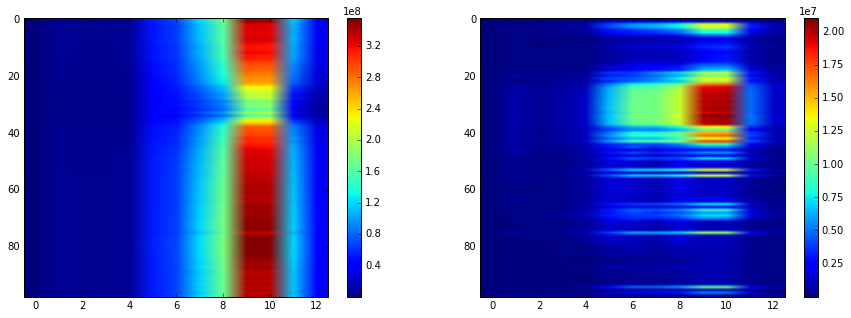

In [3]:
pl.figure(figsize=(15,5))
pl.subplot(121)
pl.imshow(fd_all, aspect='auto')
pl.colorbar()
pl.subplot(122)
pl.imshow(fd_all_err, aspect='auto')
pl.colorbar()

In [4]:
band_centers = [90e-6, 100e-6, 140e-6, 160e-6, 350e-6, 550e-6] # [m] Only bands > 70 microns for this modified blackbody fitting.
lam = np.array(band_centers)
nregions = len(fd_all)
nbands = len(band_centers)
print nregions, nbands

98 6


minimize chi-square
---

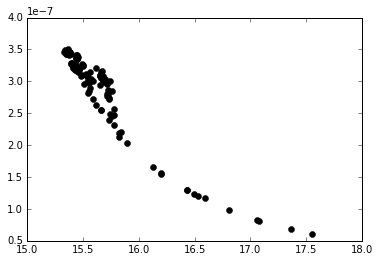

In [5]:
def objective_chisq(theta, wave, flux, uflux):
    temp, tau = theta
    model = modified_blackbody(wave, temp, tau)
    return np.sum(((flux - model) / uflux) ** 2)

optima = []
for region in range(nregions):
    fir_flux = fd_all[region,7:]
    fir_flux.max()
    fir_max = fir_flux.max()
    idx = fir_flux == fir_max
    lam_peak = lam[idx]
    initial = (wiens_temp(lam_peak), 1e-6)

    flux = fd_all[region,7:]
    uflux = fd_all_err[region,7:]
    args = (lam, flux, uflux)

    opt = op.minimize(objective_chisq, initial, args=args, method='nelder-mead')
#     print "region {} optimum: T = {}, tau = {}".format(region, *opt.x)
    optima.append(opt.x)

temp, tau = zip(*optima)
pl.plot(temp, tau, 'ko')

maximum likelihood
---

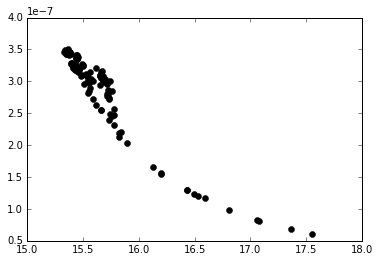

In [6]:
def loglike(theta, wave, flux, uflux):
    temp, tau = theta
    model = modified_blackbody(wave, temp, tau)
    inv_sig2 = (1. / uflux) ** 2
    return -0.5 * np.sum( (flux - model) ** 2 * inv_sig2 - np.log(inv_sig2) )

nll = lambda *args: -loglike(*args)
optima = []
for region in range(nregions):
    fir_flux = fd_all[region,7:]
    fir_flux.max()
    fir_max = fir_flux.max()
    idx = fir_flux == fir_max
    lam_peak = lam[idx]
    initial = (wiens_temp(lam_peak), 1e-6)

    flux = fd_all[region,7:]
    uflux = fd_all_err[region,7:]
    args = (lam, flux, uflux)

    opt = op.minimize(nll, initial, args=args, method='nelder-mead')
#     print "region {} optimum: T = {}, tau = {}".format(region, *opt.x)
    optima.append(opt.x)

temp, tau = zip(*optima)
pl.plot(temp, tau, 'ko')

MCMC example on a single region
---

In [7]:
def logprior(theta):
    if theta[0] > 0 and theta[1] > 0:
        return 0.0
    return -np.inf

def logprob(theta, wave, flux, uflux):
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta, wave, flux, uflux)

region = 0
fir_flux = fd_all[region,7:]
fir_flux.max()
fir_max = fir_flux.max()
idx = fir_flux == fir_max
lam_peak = lam[idx][0]
initial = (wiens_temp(lam_peak), 1e-6)

flux = fd_all[region,7:]
uflux = fd_all_err[region,7:]
args = (lam, flux, uflux)

import emcee
ndim = 2
nwalkers = ndim * 64
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=4)
p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
p0, lnp, _ = sampler.run_mcmc(p0, 500)

burn-in
---

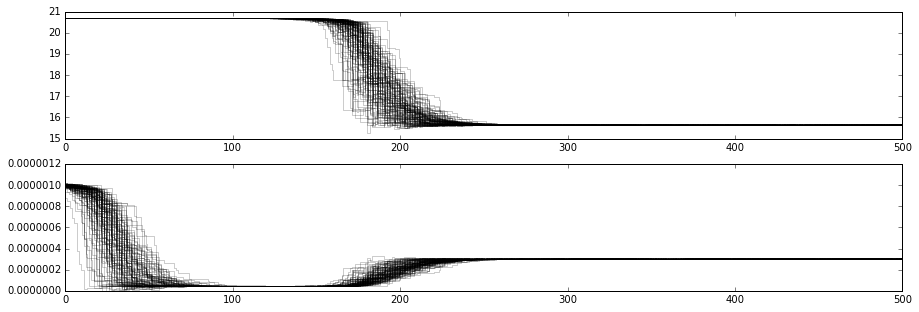

In [8]:
pl.figure(figsize=(15,5))
for i, chain in enumerate(sampler.chain.T):
    pl.subplot(2,1,i+1)
    pl.plot(chain, drawstyle='steps', color='k', alpha=0.2)

In [9]:
p = p0[np.argmax(lnp)]
p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 1000)

production
---

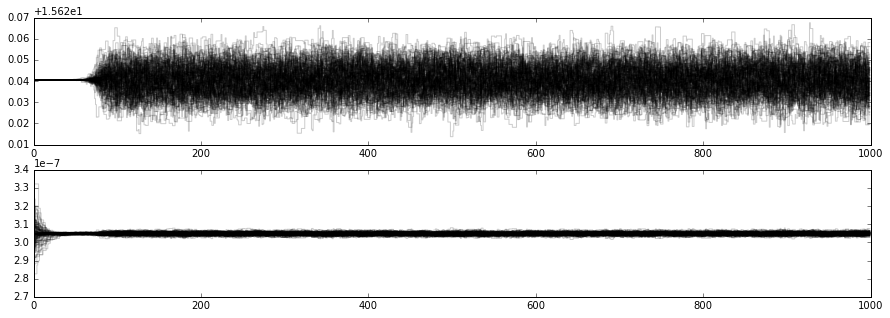

In [10]:
pl.figure(figsize=(15,5))
for i, chain in enumerate(sampler.chain.T):
    pl.subplot(2,1,i+1)
    pl.plot(chain, drawstyle='steps', color='k', alpha=0.2)

/home/jhl/miniconda2/envs/etp/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/jhl/miniconda2/envs/etp/lib/python2.7/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


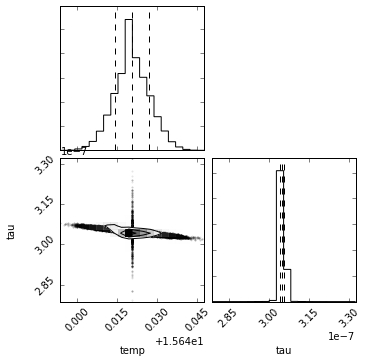

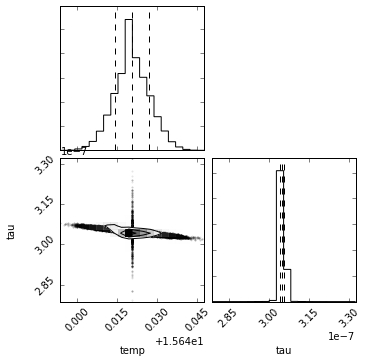

In [11]:
import corner
chains = sampler.flatchain[100:]
corner.corner(chains, labels=['temp', 'tau'], quantiles=[0.16, 0.5, 0.84])

In [12]:
pct = zip(*np.percentile(chains, (16, 50, 84), axis=0))
mu, sigma = zip(*map(lambda x: (x[1], (x[2]-x[1], x[1]-x[0])), pct))
print "temp = {} +/-({}, {})".format(mu[0], *sigma[0])
print "tau = {} +/-({}, {})".format(mu[1], *sigma[1])

temp = 15.6606200938 +/-(0.0064357813751, 0.00647963628806)
tau = 3.04848175741e-07 +/-(7.76952261146e-10, 7.8371071694e-10)
